### Testing Features ###

In [2]:
import cv2
import numpy as np
import os
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


In [3]:
def extract_glcm_features(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the GLCM (Gray Level Co-occurrence Matrix)
    glcm = greycomatrix(gray_image, distances=[1], angles=[0], symmetric=True, normed=True)
    
    # Extract texture properties: Contrast, Correlation, Energy, and Homogeneity
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    
    return [contrast, correlation, energy, homogeneity]


In [4]:
def extract_hog_features(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute HOG features
    hog_features, hog_image = hog(gray_image, 
                                  pixels_per_cell=(16, 16), 
                                  cells_per_block=(2, 2), 
                                  block_norm='L2-Hys', 
                                  visualize=True, 
                                  multichannel=False)
    
    return hog_features


In [5]:
def load_images_from_folder(folder):
    images = []
    labels = []
    
    # Loop through subfolders, where each folder represents a class (e.g., Benign or Malignant)
    for label_folder in os.listdir(folder):
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path)  # Read the image
                if img is not None:
                    images.append(img)
                    labels.append(label_folder)  # The folder name becomes the class label
    return images, labels


In [6]:
def prepare_data(X_images):
    X_features = []
    
    for img in X_images:
        # Extract GLCM (texture) features
        glcm_features = extract_glcm_features(img)
        
        # Extract HOG (shape) features
        hog_features = extract_hog_features(img)
        
        # Combine both sets of features
        combined_features = np.concatenate((glcm_features, hog_features))
        
        # Add the combined features to the feature list
        X_features.append(combined_features)
        
    return np.array(X_features)


In [8]:
# Load dataset (assuming images are stored in 'data' folder)
X_images, y_labels = load_images_from_folder('ISIC-images')

# Prepare feature set by extracting features from the images
X_features = prepare_data(X_images)

# Split dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)

# Scale the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [9]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew

def preprocess_image(image_path, target_size=(300, 300)):
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize
    img = cv2.resize(img, target_size)
    
    # Extract the circular region of interest
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (img.shape[1]//2, img.shape[0]//2), min(img.shape[0], img.shape[1])//2 - 10, (255), -1)
    img = cv2.bitwise_and(img, img, mask=mask)
    
    # Enhance contrast
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl,a,b))
    img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    
    # Normalize
    img = img.astype(np.float32) / 255.0
    
    return img

def extract_color_features(img):
    features = []
    
    # Color moments (mean, std, skewness) for each channel
    for i in range(3):
        channel = img[:,:,i]
        features.extend([channel[channel != 0].mean(), channel[channel != 0].std(), skew(channel[channel != 0].ravel())])
    
    # Color histograms
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [32], [0, 1])
        features.extend(hist.flatten())
    
    return features

def extract_texture_features(img):
    features = []
    
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Local Binary Patterns
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    features.extend(hist)
    
    # Haralick texture features
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    for prop in props:
        features.extend(graycoprops(glcm, prop).flatten())
    
    return features

def extract_shape_features(img):
    features = []
    
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        
        # Area and Perimeter
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        features.extend([area, perimeter])
        
        # Circularity
        circularity = 4 * np.pi * area / (perimeter ** 2)
        features.append(circularity)
        
        # Asymmetry
        (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
        asymmetry = MA / ma
        features.append(asymmetry)
        
        # Border irregularity
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area
        features.append(solidity)
    else:
        features.extend([0] * 5)  # Placeholder if no contour found
    
    return features

def analyze_lesion(image_path):
    img = preprocess_image(image_path)
    
    color_features = extract_color_features(img)
    texture_features = extract_texture_features(img)
    shape_features = extract_shape_features(img)
    
    all_features = np.concatenate([color_features, texture_features, shape_features])
    
    return all_features

# Usage
image_path = "path_to_your_image.jpg"
features = analyze_lesion(image_path)
print(f"Extracted {len(features)} features from the image.")

[ WARN:0@400.466] global loadsave.cpp:241 findDecoder imread_('path_to_your_image.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [12]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew
from tqdm import tqdm

def preprocess_image(img, target_size=(300, 300)):
    # Resize
    img = cv2.resize(img, target_size)
    
    # Extract the circular region of interest
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (img.shape[1]//2, img.shape[0]//2), min(img.shape[0], img.shape[1])//2 - 10, (255), -1)
    img = cv2.bitwise_and(img, img, mask=mask)
    
    # Enhance contrast
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl,a,b))
    img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    
    # Normalize
    img = img.astype(np.float32) / 255.0
    
    return img

def extract_color_features(img):
    features = []
    
    # Color moments (mean, std, skewness) for each channel
    for i in range(3):
        channel = img[:,:,i]
        features.extend([channel[channel != 0].mean(), channel[channel != 0].std(), skew(channel[channel != 0].ravel())])
    
    # Color histograms
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [32], [0, 1])
        features.extend(hist.flatten())
    
    return features

def extract_texture_features(img):
    features = []
    
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Local Binary Patterns
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    features.extend(hist)
    
    # Haralick texture features
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    for prop in props:
        features.extend(graycoprops(glcm, prop).flatten())
    
    return features

def extract_shape_features(img):
    features = []
    
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        
        # Area and Perimeter
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        features.extend([area, perimeter])
        
        # Circularity
        circularity = 4 * np.pi * area / (perimeter ** 2)
        features.append(circularity)
        
        # Asymmetry
        (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
        asymmetry = MA / ma
        features.append(asymmetry)
        
        # Border irregularity
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area
        features.append(solidity)
    else:
        features.extend([0] * 5)  # Placeholder if no contour found
    
    return features

def analyze_lesion(img):
    img = preprocess_image(img)
    
    color_features = extract_color_features(img)
    texture_features = extract_texture_features(img)
    shape_features = extract_shape_features(img)
    
    all_features = np.concatenate([color_features, texture_features, shape_features])
    
    return all_features

def process_image_folder(folder_path):
    all_features = []
    image_names = []
    
    # Get all image files
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for image_file in tqdm(image_files, desc="Processing images"):
        image_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        features = analyze_lesion(img)
        all_features.append(features)
        image_names.append(image_file)
    
    # Create a DataFrame with the features
    feature_names = [f'feature_{i}' for i in range(len(all_features[0]))]
    df = pd.DataFrame(all_features, columns=feature_names)
    df['image_name'] = image_names
    
    return df

# Usage
folder_path = "/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/ISIC-images"
results_df = process_image_folder(folder_path)

# Save the results
results_df.to_csv("skin_lesion_features.csv", index=False)
print(f"Processed {len(results_df)} images. Results saved to 'skin_lesion_features.csv'")

Processing images: 100%|██████████| 100/100 [00:04<00:00, 22.21it/s]

Processed 100 images. Results saved to 'skin_lesion_features.csv'


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew
from tqdm import tqdm

def preprocess_image(img, target_size=(300, 300)):
    # Resize
    img = cv2.resize(img, target_size)
    
    # Extract the circular region of interest
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (img.shape[1]//2, img.shape[0]//2), min(img.shape[0], img.shape[1])//2 - 10, (255), -1)
    img = cv2.bitwise_and(img, img, mask=mask)
    
    # Enhance contrast
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl,a,b))
    img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    
    # Normalize
    img = img.astype(np.float32) / 255.0
    
    return img

def extract_color_features(img):
    features = {}
    channels = ['R', 'G', 'B']
    
    # Color moments (mean, std, skewness) for each channel
    for i, channel in enumerate(channels):
        channel_data = img[:,:,i]
        features[f'color_mean_{channel}'] = channel_data[channel_data != 0].mean()
        features[f'color_std_{channel}'] = channel_data[channel_data != 0].std()
        features[f'color_skew_{channel}'] = skew(channel_data[channel_data != 0].ravel())
    
    # Color histograms
    for i, channel in enumerate(channels):
        hist = cv2.calcHist([img], [i], None, [32], [0, 1])
        for j, value in enumerate(hist.flatten()):
            features[f'color_hist_{channel}_{j}'] = value
    
    return features

def extract_texture_features(img):
    features = {}
    
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Local Binary Patterns
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    for i, value in enumerate(hist):
        features[f'lbp_{i}'] = value
    
    # Haralick texture features
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    for prop in props:
        value = graycoprops(glcm, prop)[0, 0]
        features[f'haralick_{prop}'] = value
    
    return features

def extract_shape_features(img):
    features = {}
    
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        
        # Area and Perimeter
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        features['shape_area'] = area
        features['shape_perimeter'] = perimeter
        
        # Circularity
        circularity = 4 * np.pi * area / (perimeter ** 2)
        features['shape_circularity'] = circularity
        
        # Asymmetry
        (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
        asymmetry = MA / ma
        features['shape_asymmetry'] = asymmetry
        
        # Border irregularity
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area
        features['shape_border_irregularity'] = solidity
    else:
        for feature in ['shape_area', 'shape_perimeter', 'shape_circularity', 'shape_asymmetry', 'shape_border_irregularity']:
            features[feature] = 0
    
    return features

def analyze_lesion(img):
    img = preprocess_image(img)
    
    features = {}
    features.update(extract_color_features(img))
    features.update(extract_texture_features(img))
    features.update(extract_shape_features(img))
    
    return features

def process_image_folder(folder_path):
    all_features = []
    image_names = []
    
    # Get all image files
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for image_file in tqdm(image_files, desc="Processing images"):
        image_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        features = analyze_lesion(img)
        all_features.append(features)
        image_names.append(image_file)
    
    # Create a DataFrame with the features
    df = pd.DataFrame(all_features)
    df['image_name'] = image_names
    
    return df

# Usage
folder_path = "/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/ISIC-images"
results_df = process_image_folder(folder_path)

# Save the results
results_df.to_csv("skin_lesion_features.csv", index=False)
print(f"Processed {len(results_df)} images. Results saved to 'skin_lesion_features.csv'")
print(f"Total number of features: {len(results_df.columns) - 1}")  # -1 for the image_name column

Processing images: 100%|██████████| 100/100 [00:04<00:00, 23.22it/s]

Processed 100 images. Results saved to 'skin_lesion_features.csv'
Total number of features: 141


SVM Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
SVM Best Score: 0.5875

SVM Classification Report:
              precision    recall  f1-score   support

      benign       0.40      1.00      0.57         8
   malignant       0.00      0.00      0.00        12

    accuracy                           0.40        20
   macro avg       0.20      0.50      0.29        20
weighted avg       0.16      0.40      0.23        20



/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being s


MLP Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
MLP Best Score: 0.5625

MLP Classification Report:
              precision    recall  f1-score   support

      benign       0.50      0.75      0.60         8
   malignant       0.75      0.50      0.60        12

    accuracy                           0.60        20
   macro avg       0.62      0.62      0.60        20
weighted avg       0.65      0.60      0.60        20



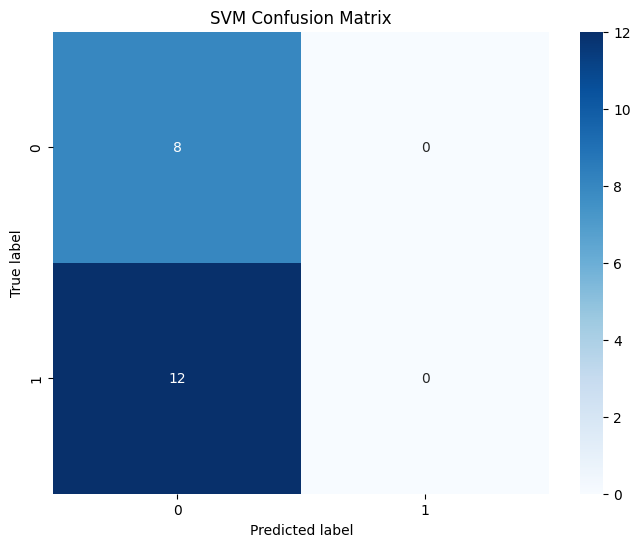

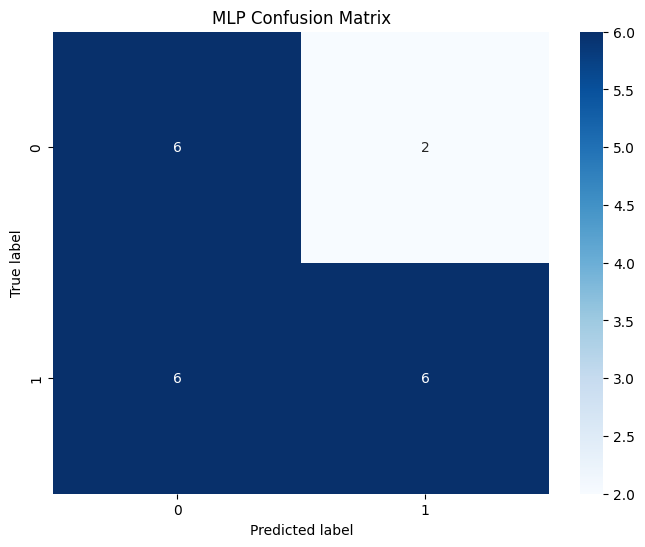


SVM Predictions on new data: ['benign' 'benign' 'benign' 'benign' 'benign']
MLP Predictions on new data: ['malignant' 'benign' 'benign' 'malignant' 'malignant']


In [6]:
import pandas as pd #Pandas#
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("skin_lesion_features.csv")

# Assume we have a target variable called 'label'
# For this example, we'll create a dummy target variable
df['label'] = np.random.choice(['benign', 'malignant'], size=len(df))

# Separate features and target
X = df.drop(['image_name', 'label'], axis=1)
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Model
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

svm_grid = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=5, n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

print("SVM Best Parameters:", svm_grid.best_params_)
print("SVM Best Score:", svm_grid.best_score_)

svm_pred = svm_grid.predict(X_test_scaled)
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_pred))

# MLP Model
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

mlp_grid = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), mlp_param_grid, cv=5, n_jobs=-1)
mlp_grid.fit(X_train_scaled, y_train)

print("\nMLP Best Parameters:", mlp_grid.best_params_)
print("MLP Best Score:", mlp_grid.best_score_)

mlp_pred = mlp_grid.predict(X_test_scaled)
print("\nMLP Classification Report:")
print(classification_report(y_test, mlp_pred))

# Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(y_test, svm_pred, "SVM Confusion Matrix")
plot_confusion_matrix(y_test, mlp_pred, "MLP Confusion Matrix")

# Feature Importance (for SVM with linear kernel)
if svm_grid.best_estimator_.kernel == 'linear':
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': abs(svm_grid.best_estimator_.coef_[0])
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title('Top 20 Important Features (SVM)')
    plt.show()

# Predictions on new data
new_data = X_test_scaled[:5]  # Using first 5 samples of test set as example
svm_new_pred = svm_grid.predict(new_data)
mlp_new_pred = mlp_grid.predict(new_data)

print("\nSVM Predictions on new data:", svm_new_pred)
print("MLP Predictions on new data:", mlp_new_pred)